In [0]:
!pip install IMDbPY

In [0]:
%matplotlib inline

In [0]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from imdb import IMDb
import collections
import re
from google.colab import files

## Load TNG reference and load episodes list


In [0]:
imdb = IMDb()

STAR_TREK_THE_NEXT_GENERATION_IMDB_ID = '0092455'
tng = imdb.get_movie(STAR_TREK_THE_NEXT_GENERATION_IMDB_ID)

imdb.update(tng, 'episodes')

## Load episode data 

Calling `imdb.update(episode)` adds the detailed episode data we need later like `rating` and `cast` to the episode/movie
instance.

In [0]:
def load_episode_data(imdb, series):
  for season_id in sorted(series['episodes']):
    print('\nloading episode data for season' + str(season_id) + ':', end='')
    for espisode_id in series['episodes'][season_id]:
      imdb.update(series['episodes'][season_id][espisode_id])
      print('.' , end='')

In [0]:
load_episode_data(imdb, tng)


loading episode data for season1:.........................
loading episode data for season2:......................
loading episode data for season3:..........................
loading episode data for season4:..........................
loading episode data for season5:..........................
loading episode data for season6:..........................
loading episode data for season7:.........................

## Non-altime cast

In [0]:
whoopi_goldberg = {'id':'0000155','name':'Whoopi Goldberg', 'character':'Guinan'}
denise_crosby   = {'id':'0000344','name':'Denise Crosby', 'character':'Tasha Yar / Sela'} 
gates_mcfadden  = {'id':'0000533','name':'Gates McFadden', 'character':'Dr. Beverly Crusher'}
colm_meaney     = {'id':'0000538','name':'Colm Meaney', 'character':'Chief Miles O\'Brien'}
wil_wheaton     = {'id':'0000696','name':'Wil Wheaton', 'character':'Wesley Crusher'}
john_de_lancie  = {'id':'0209496','name':'John de Lancie', 'character':'Q'}
diana_muldaur   = {'id':'0611707','name':'Diana Muldaur', 'character':'Doctor Pulaski'}
dwight_schultz  = {'id':'0776239','name':'Dwight Schultz', 'character':'Barclay'}

In [0]:
def actor_is_in_episode(episode, actor):
  for actor_in_cast in episode['cast']:
    if actor_in_cast.personID == actor['id']:
      return True
  return False

## Prepare data to be plotted

In [0]:
def get_ratings_and_titles(series):
  ratings = []
  titles = []
  
  for season_id in sorted(series['episodes']):
    for episode_id in series['episodes'][season_id]:
      episode = series['episodes'][season_id][episode_id]
      titles.append(episode['title'] + ' (S{:02d}E{:02d})'.format(season_id, episode_id))
      ratings.append(episode['rating'])
            
  return ratings, titles

In [0]:
def actor_appears_in_episodes(series, actor):
  actor_appears_in_episodes = []
 
  for season_id in sorted(series['episodes']):
    for episode_id in series['episodes'][season_id]:
      episode = series['episodes'][season_id][episode_id]
      actor_appears_in_episodes.append(actor_is_in_episode(episode, actor))

  return actor_appears_in_episodes

In [0]:
def get_episode_appearances_for_two_actors(series, actor1, actor2):
  actor1_in_episodes = actor_appears_in_episodes(series, actor1)
  actor2_in_episodes = actor_appears_in_episodes(series, actor2)
  both_actors_appear_in_episode = np.logical_and(actor1_in_episodes, actor2_in_episodes)
  non_of_the_actors_appear_in_episode =  np.logical_not(np.logical_or(actor1_in_episodes, actor2_in_episodes))
  # only_actor1_in_episodes = np.logical_xor(both_actors_appear_in_episode, actor1_in_episodes)
  # only_actor2_in_episodes = np.logical_xor(both_actors_appear_in_episode, actor2_in_episodes)
  
  return (actor1_in_episodes, actor2_in_episodes, both_actors_appear_in_episode, non_of_the_actors_appear_in_episode)

In [0]:
def get_color_for_two_actors(actor1_appearance, actor2_appearance):  
  if (actor1_appearance and actor2_appearance):
    return 'green'
  if actor1_appearance:
    return 'blue'
  if actor2_appearance:
    return 'red'
  return 'grey'

## Calculate the average rating for actor appearances 

In [0]:
def get_average(sum_ratings, count):
  if count == 0:
    return 0
  return sum_ratings / count

In [0]:
def get_average_for_appearances(ratings, appearances):
  return get_average(
      sum((rating * appearance) for rating, appearance in zip (ratings, appearances)),
      appearances.count(True))

In [0]:
def get_average_ratings_for_two_actors(series, ratings, actor1, actor2):
    actor1_in_episodes, actor2_in_episodes, both_actors_appear_in_episode, non_of_the_actors_appear_in_episode = get_episode_appearances_for_two_actors(series, actor1, actor2)
    
    actor1_average_rating = get_average_for_appearances(ratings, list(actor1_in_episodes))
    actor2_average_rating = get_average_for_appearances(ratings, list(actor2_in_episodes))
    both_actors_average_rating = get_average_for_appearances(ratings, list(both_actors_appear_in_episode))
    non_of_the_actors_average_rating = get_average_for_appearances(ratings, list(non_of_the_actors_appear_in_episode))
    
    
    return actor1_average_rating, actor2_average_rating, both_actors_average_rating, non_of_the_actors_average_rating

In [0]:
def get_printable_average_ratings_for_two_actors(series, ratings, actor1, actor2):
  actor1_average_rating, actor2_average_rating, both_actors_average_rating, non_of_the_actors_average_rating = get_average_ratings_for_two_actors(series, ratings, actor1, actor2)
  
  return 'Average episode rating with {}: {}'.format(actor1['name'], actor1_average_rating) + '\n' \
         'Average episode rating with {}: {}'.format(actor2['name'], actor2_average_rating) + '\n' \
         'Average episode rating with {}: {}'.format('both', both_actors_average_rating) + '\n' \
         'Average episode rating with {}: {}'.format('none', non_of_the_actors_average_rating)

In [0]:
def get_printable_average_ratings(series, ratings, actor):
 
  appearances = actor_appears_in_episodes(series, actor)
  
  average_ratings_with_actor = get_average_for_appearances(ratings, appearances)
  average_ratings_without_actor = get_average_for_appearances(ratings, list(np.logical_not(appearances)))

  return 'Average episode rating with {}: {}'.format(actor['name'], average_ratings_with_actor) + '\n' \
         'Average episode rating without {}: {}'.format(actor['name'], average_ratings_without_actor)


## Plot ratings

In [0]:
def plot_ratings(ratings, titles, bar_colors, title, averages):
    index = np.arange(len(titles))
    plt.figure(figsize=(40,7))
    plt.bar(titles, ratings, color=bar_colors)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Rating\n(Average: {})'.format(sum(ratings) / len(ratings)) , fontsize=20)
    plt.xticks(index, titles, fontsize=11, rotation=90)
    plt.title(title, fontsize=20)

    plt.figtext(0.127, 0.78, averages, horizontalalignment='left',
            fontsize=12, multialignment='left',
            bbox=dict(boxstyle="round", facecolor='#D8D8D8',
                      ec="0.5", pad=0.5, alpha=1), fontweight='bold')

    filename = re.sub(r'(?u)[^-\w.]', '', str(title + '.png').strip().replace(' ', '_'))
    plt.savefig(filename, bbox_inches = "tight")
    files.download(filename)    
        
    plt.show()

In [0]:
def plot_ratings_with_one_actor(series, actor):
  bar_colors = [('red' if is_in else 'blue') for is_in in actor_appears_in_episodes(series, actor)]
  
  ratings, titles = get_ratings_and_titles(series)

  title = '{} with(red) and without(blue) {}(as {})'.format(series['title'], actor['name'], actor['character'])
  
  averages = get_printable_average_ratings(series, ratings, actor)
  
  plot_ratings(ratings, titles, bar_colors, title, averages)

In [0]:
def plot_ratings_with_two_actors(series, actor1, actor2):
  bar_colors = [get_color_for_two_actors(actor1_appearance, actor2_appearance) for actor1_appearance, actor2_appearance in zip(actor_appears_in_episodes(series, actor1), actor_appears_in_episodes(series, actor2))]

  ratings, titles = get_ratings_and_titles(series)

  title = '{} with appearances from {}(as {}, blue) and {}(as {}, red)\n(green = both)'.format(series['title'], actor1['name'], actor1['character'], actor2['name'], actor2['character'])

  averages = get_printable_average_ratings_for_two_actors(series, ratings, actor1, actor2)
  
  plot_ratings(ratings, titles, bar_colors, title, averages)

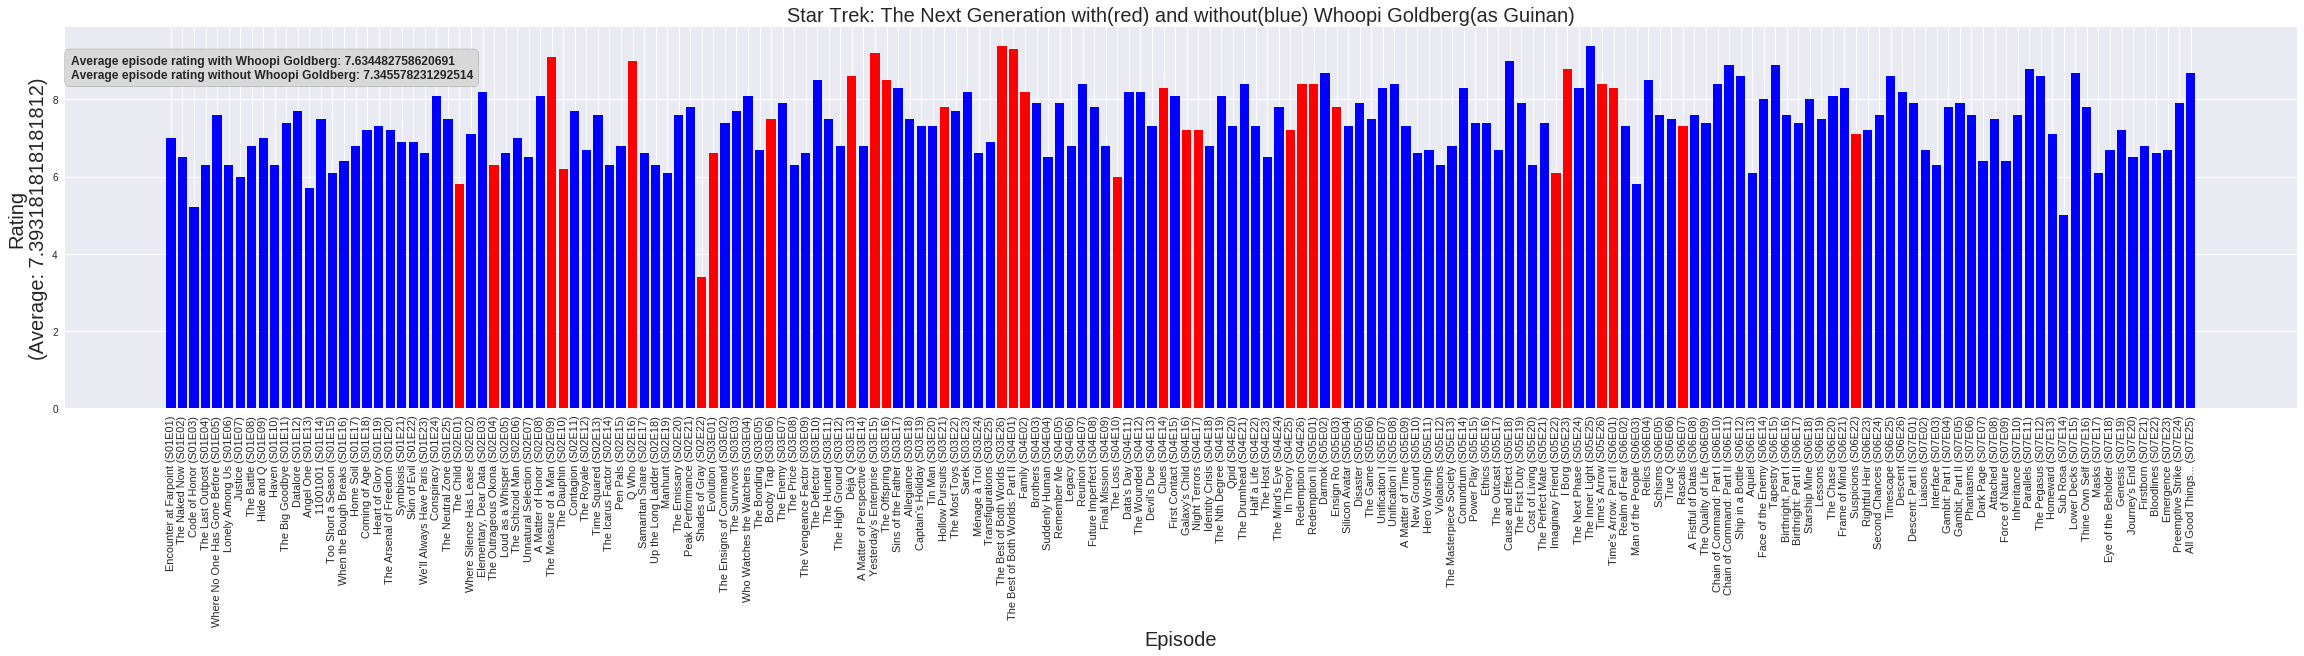

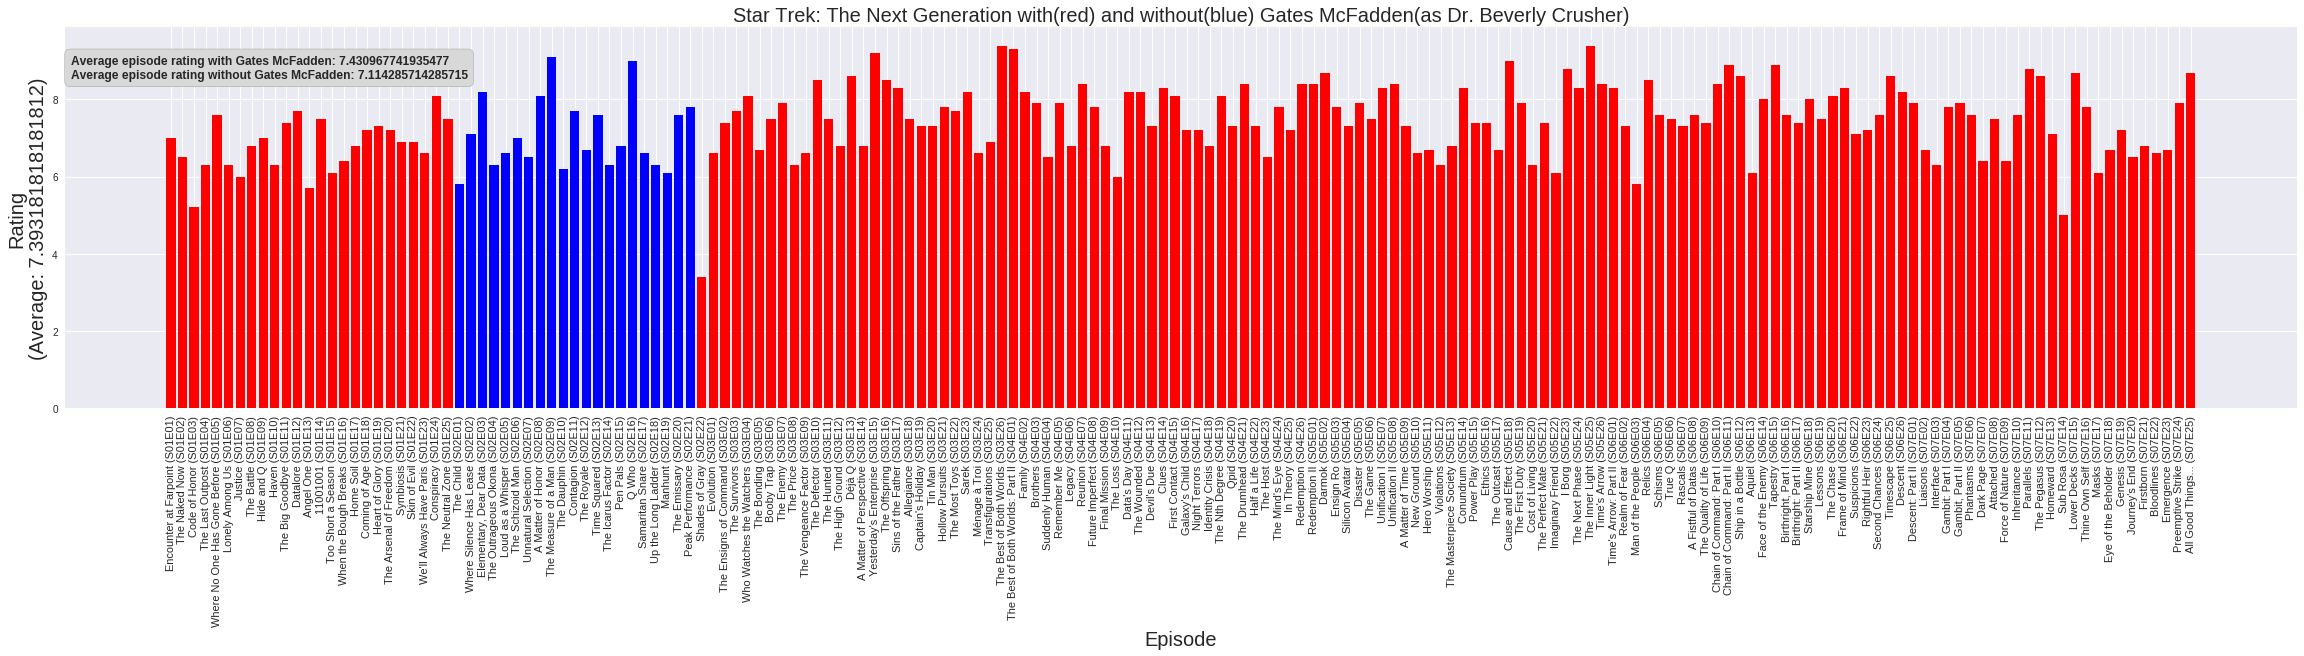

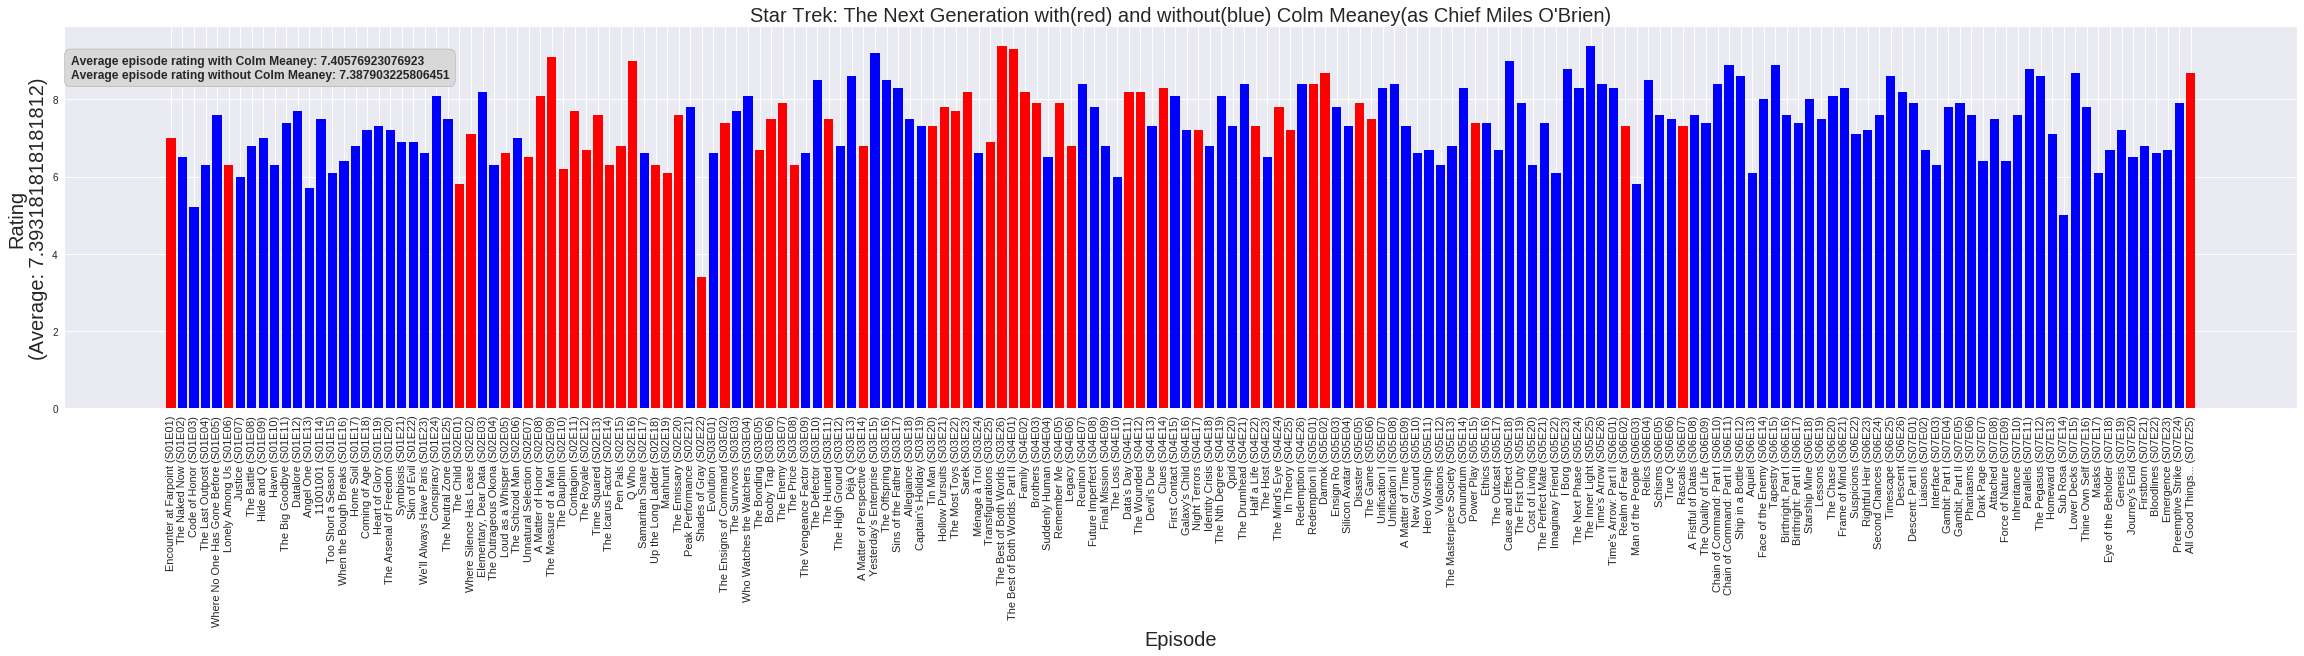

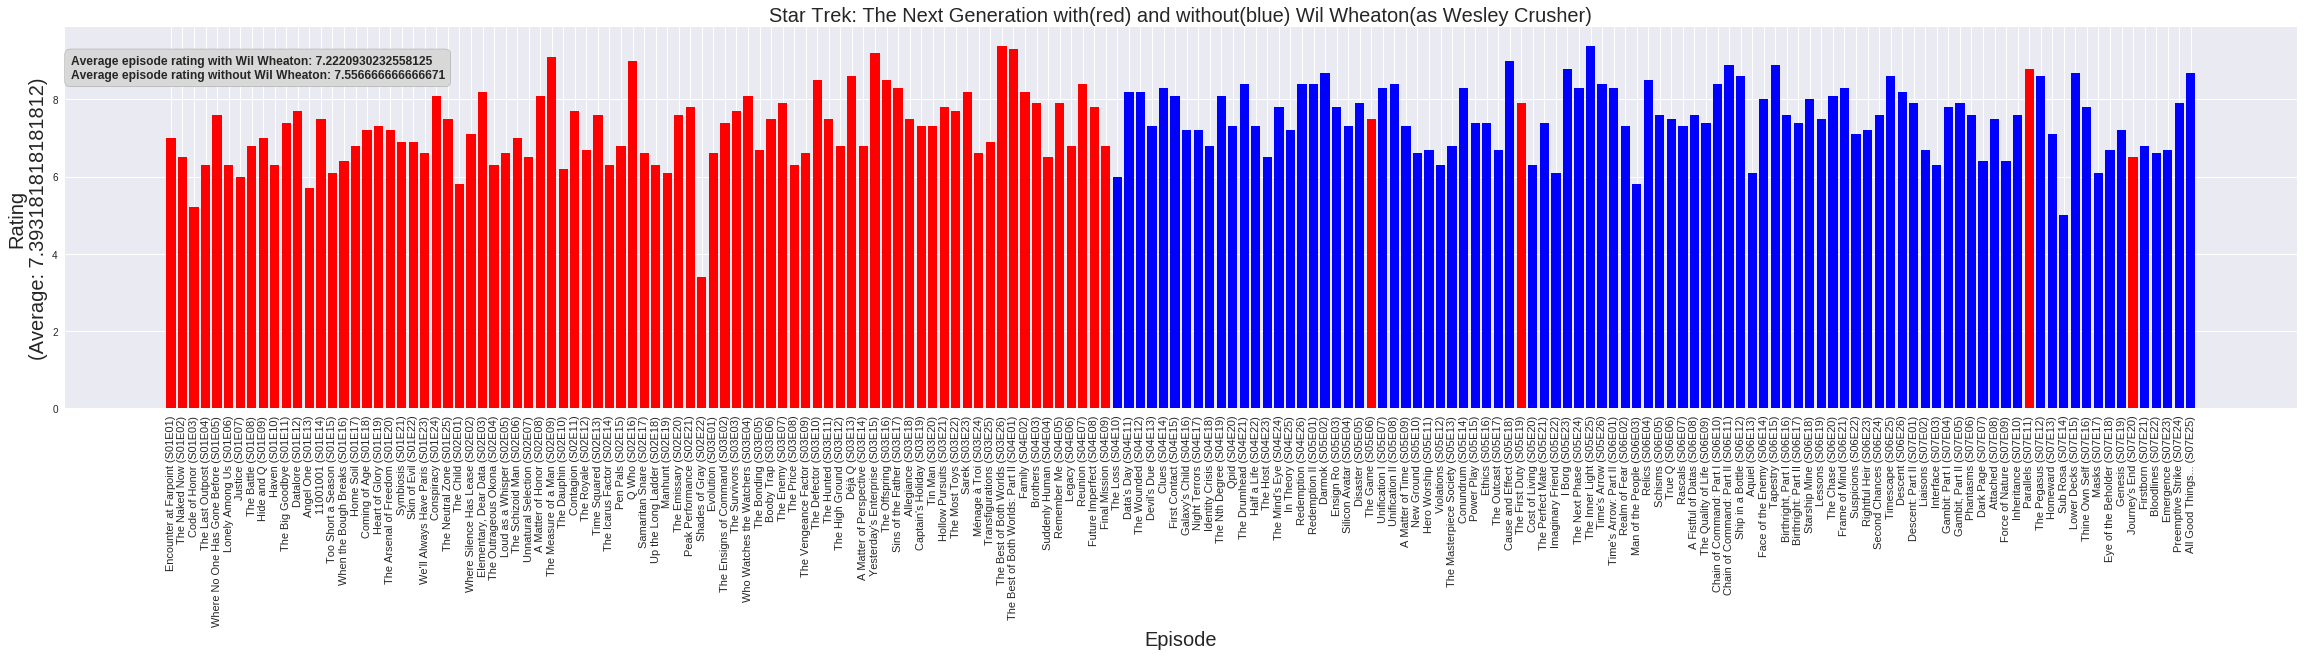

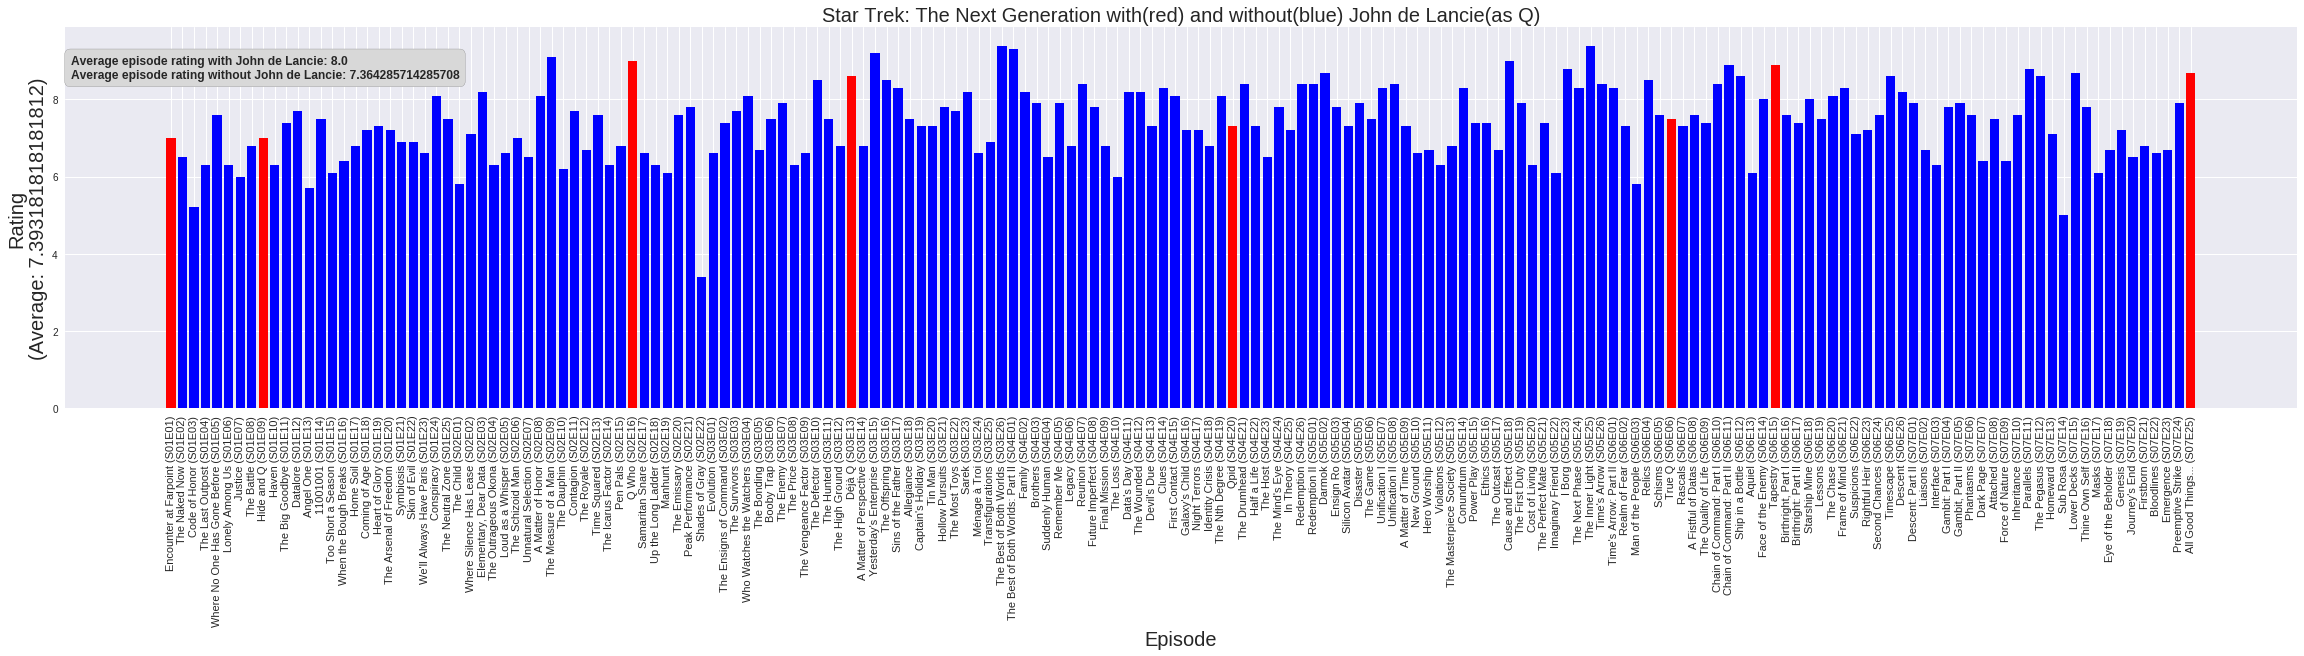

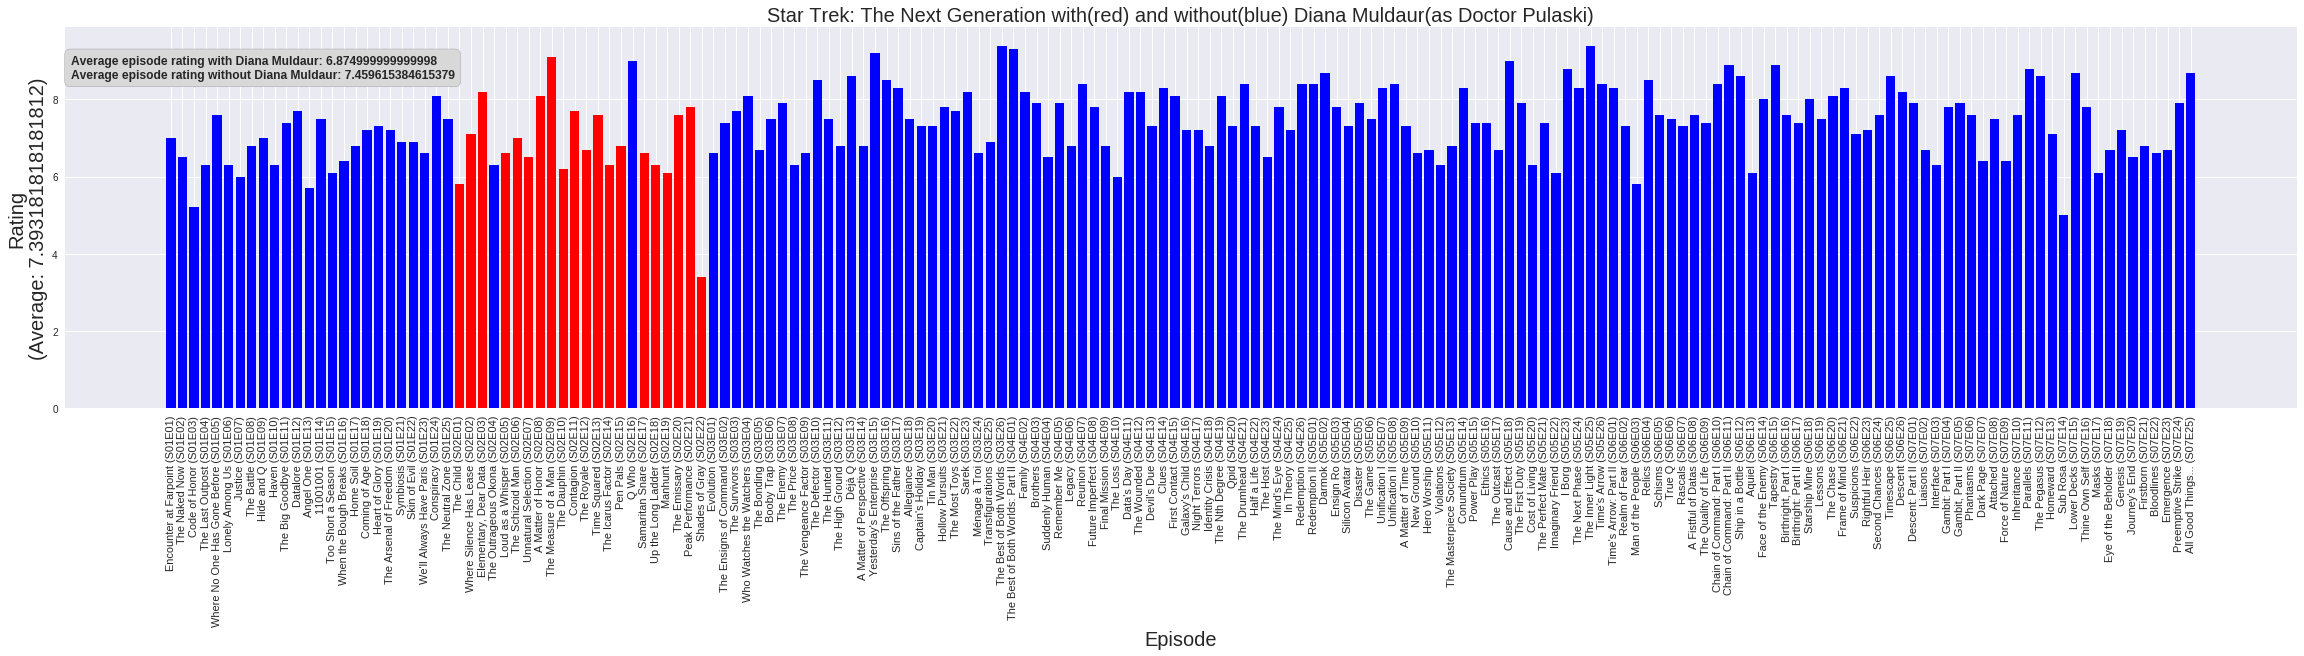

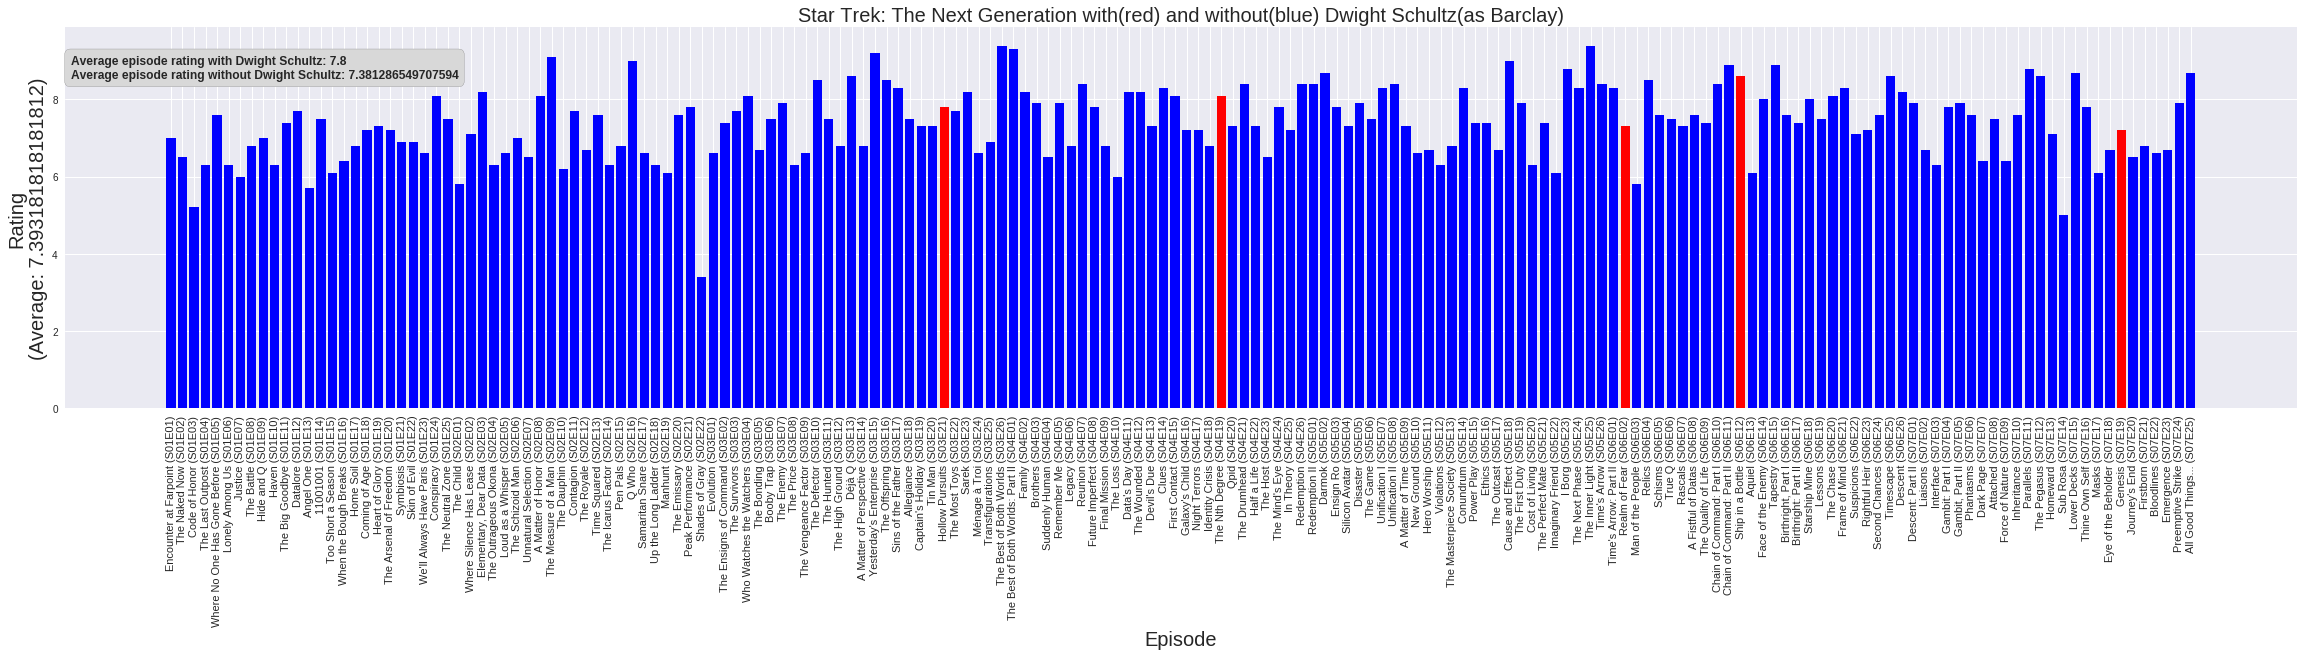

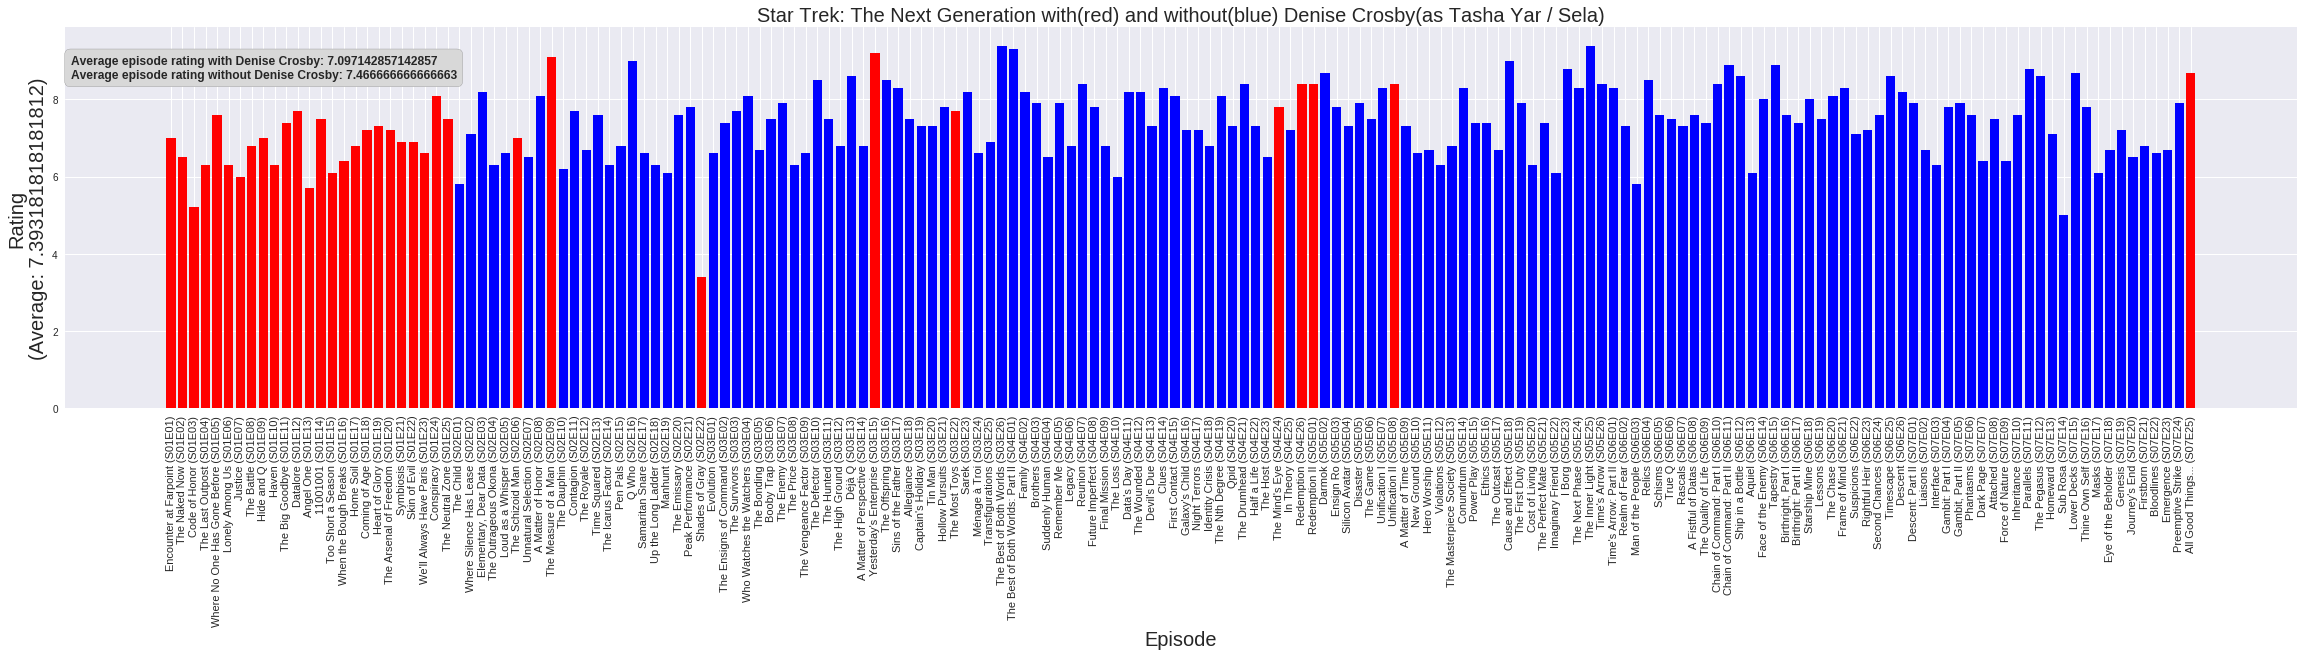

In [0]:
plot_ratings_with_one_actor(tng, whoopi_goldberg)
plot_ratings_with_one_actor(tng, gates_mcfadden)
plot_ratings_with_one_actor(tng, colm_meaney)
plot_ratings_with_one_actor(tng, wil_wheaton)
plot_ratings_with_one_actor(tng, john_de_lancie)
plot_ratings_with_one_actor(tng, diana_muldaur)
plot_ratings_with_one_actor(tng, dwight_schultz)
plot_ratings_with_one_actor(tng, denise_crosby)

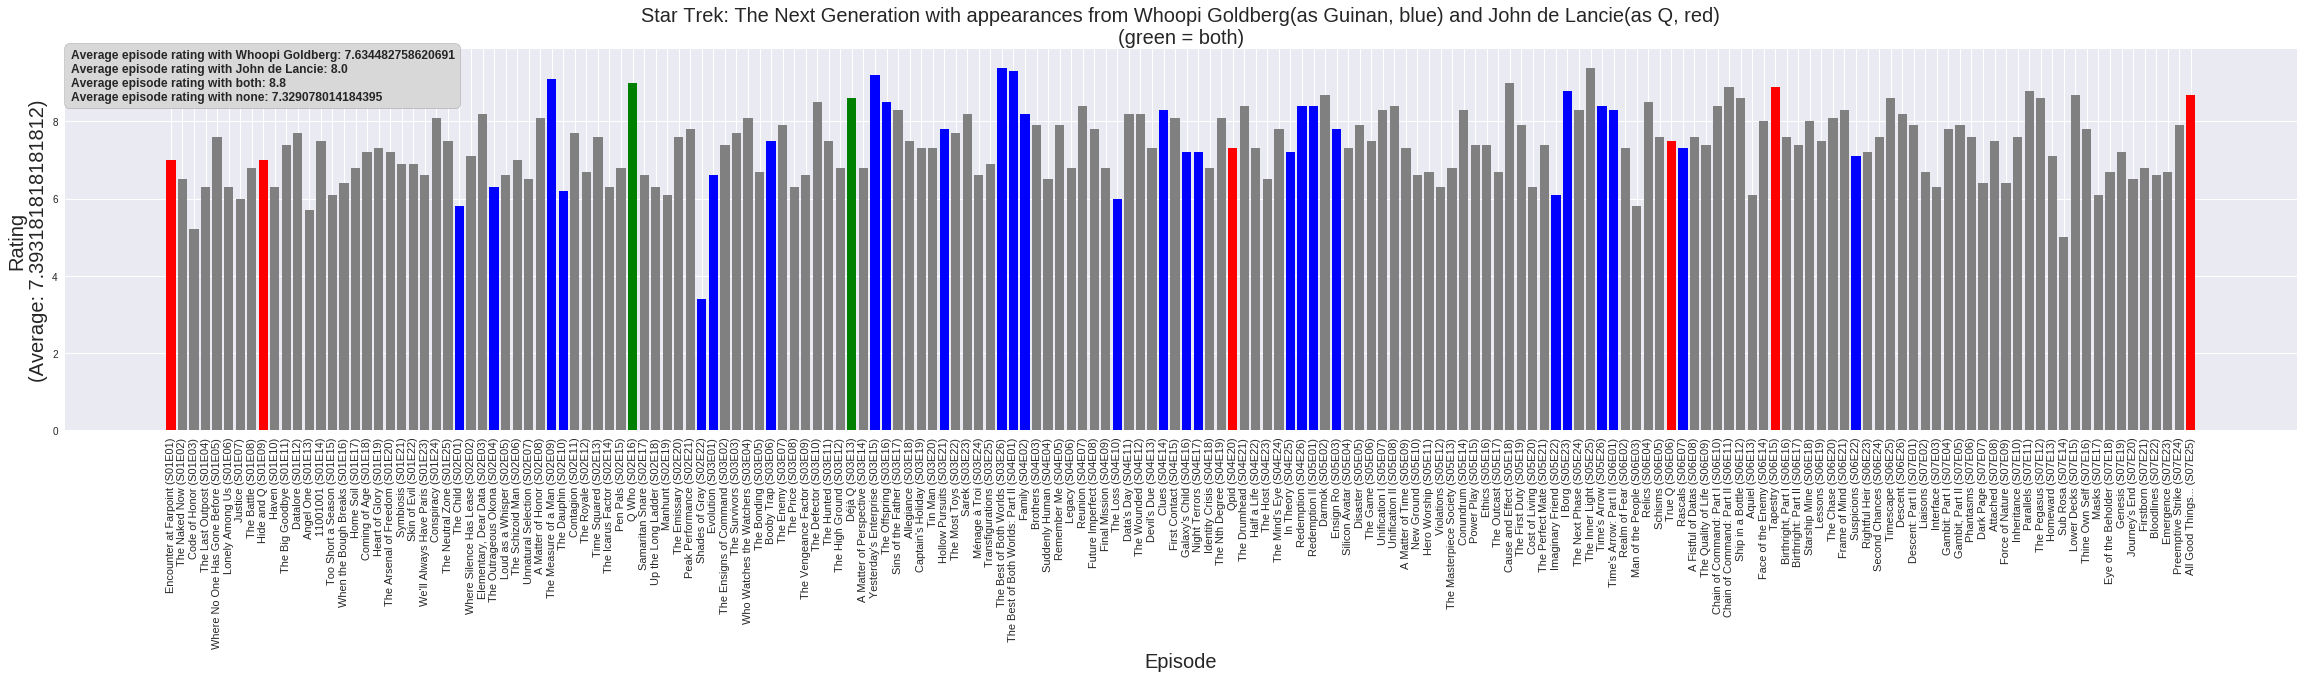

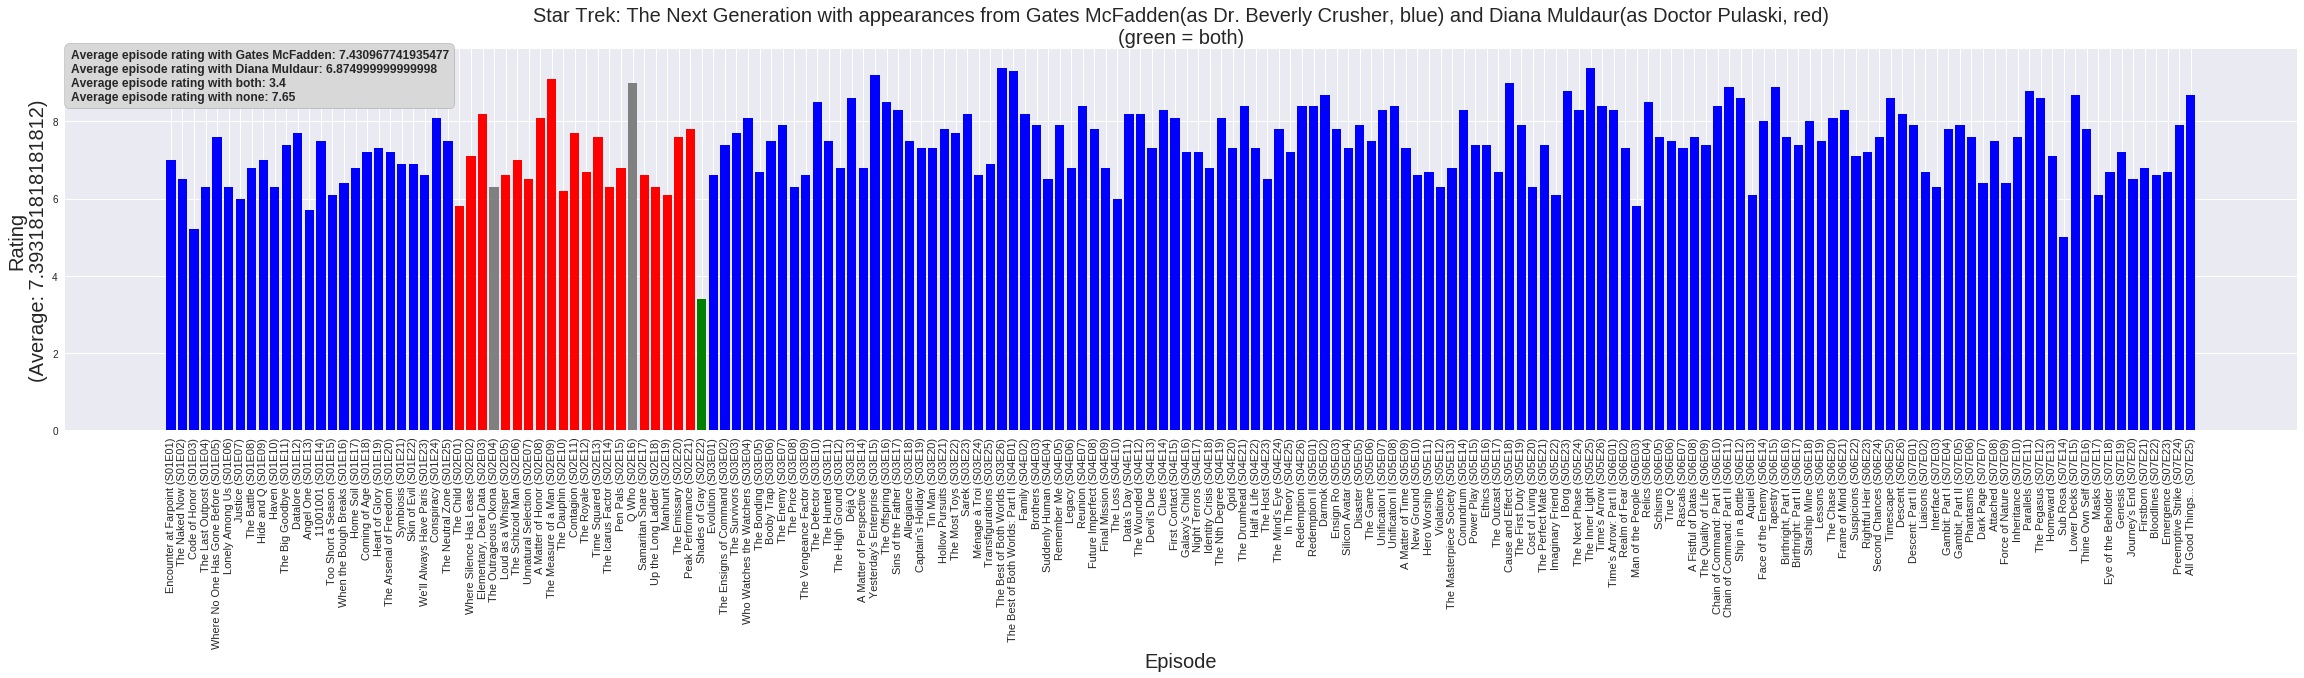

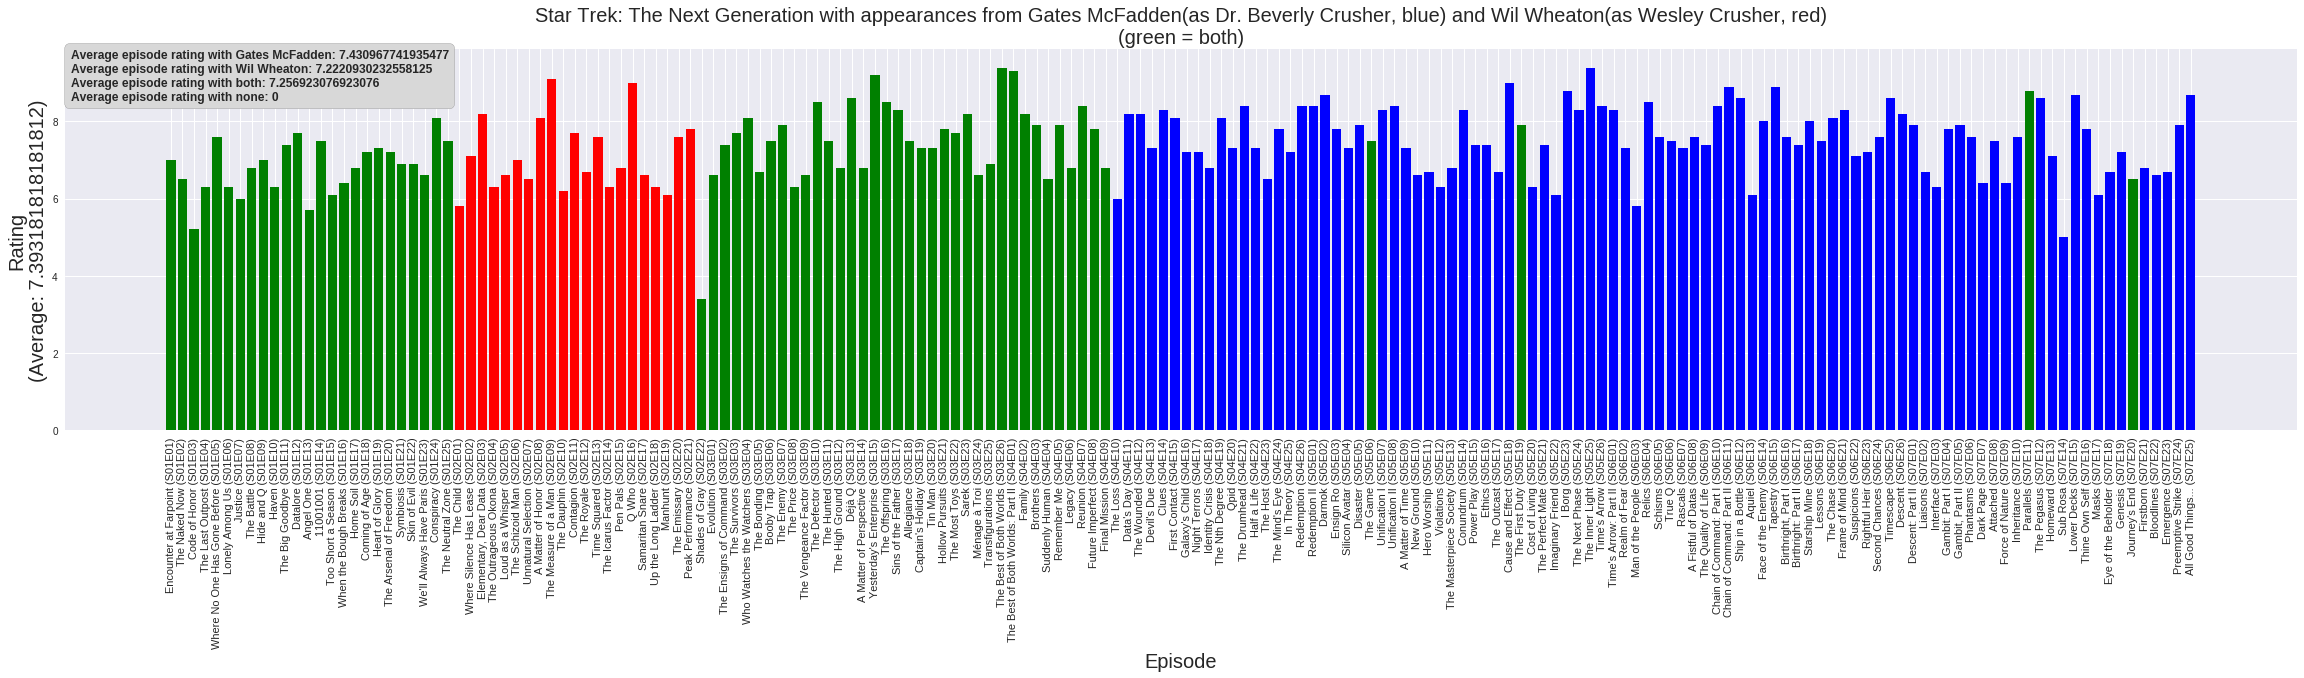

In [0]:
plot_ratings_with_two_actors(tng, whoopi_goldberg, john_de_lancie)
plot_ratings_with_two_actors(tng, gates_mcfadden, diana_muldaur)
plot_ratings_with_two_actors(tng, gates_mcfadden, wil_wheaton)